# **Import library**

In [1]:
import os
import pandas as pd
import librosa
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# **Data collection**

In [2]:
# Download dataset from google drive
file_id = '1jYCRE0n_qxSw67s9lZhNCoST5yeH-eww'
file_zip = 'dataset.zip'

drive_link = f'https://drive.google.com/uc?id={file_id}'
!gdown $drive_link -O $file_zip
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Healthy/Healthy/H41/02SOUHL/6MK2X.WAV  
   creating: dataset/Healthy/Healthy/H41/03_1SL/
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3BE.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3BER.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3KRK.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3LA.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3NOS.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PE.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PRO.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3PRST.WAV  
  inflating: dataset/Healthy/Healthy/H41/03_1SL/6MK3VLA.WAV  
   creating: dataset/Healthy/Healthy/H41/04_2SL/
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4KOLO.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4PAP.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2SL/6MK4PIVO.WAV  
  inflating: dataset/Healthy/Healthy/H41/04_2S

In [3]:
# Define path
dysarthria_path = '/content/dataset/Dysarthria'
SLI_path = '/content/dataset/SLI'
healthy_path = '/content/dataset/Healthy'

In [4]:
# Create list
category = []
speech_type = []
paths = []

# **Data pre-processing**

In [5]:
# Append file path and label
def process_directory(directory, type_label, category_label):
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.endswith('.wav'):
                paths.append(os.path.join(root, filename))
                category.append(category_label)
                speech_type.append(type_label)

In [6]:
# Populate list
process_directory(SLI_path, 'Speech Delay', 'SLI')
process_directory(dysarthria_path, 'Speech Delay', 'Dysarthria')
process_directory(healthy_path, 'Normal', 'Healthy')

In [7]:
# Create dataframe
main_df = pd.DataFrame({
    'Category': category,
    'Type': speech_type,
    'Path': paths
})

print(main_df.head())
print(main_df['Type'].value_counts())

  Category          Type                                         Path
0      SLI  Speech Delay  /content/dataset/SLI/P44/05_3SL/4vj5pok.wav
1      SLI  Speech Delay  /content/dataset/SLI/P44/05_3SL/4vj5kve.wav
2      SLI  Speech Delay  /content/dataset/SLI/P44/05_3SL/4vj5poh.wav
3      SLI  Speech Delay  /content/dataset/SLI/P44/05_3SL/4vj5ded.wav
4      SLI  Speech Delay  /content/dataset/SLI/P44/06_4SL/4vj6pop.wav
Type
Normal          2142
Speech Delay    1391
Name: count, dtype: int64


In [8]:
# Load audio files and process waveform
def load_audio_waveform(audio_path, sr=16000):
    waveform, _ = librosa.load(audio_path, sr=sr, mono=True)
    return waveform

In [9]:
# Load waveform
waveforms = []
for path in main_df['Path']:
    try:
        waveform = load_audio_waveform(path)
        waveforms.append(waveform)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        waveforms.append(None)

# Add waveform to dataframe
main_df['Waveform'] = waveforms
main_df = main_df.dropna(subset=['Waveform'])

In [10]:
# Convert 'Type' column to numerical
label_mapping = {'Speech Delay': 0, 'Normal': 1}
main_df['Label'] = main_df['Type'].map(label_mapping)

In [11]:
# Load YAMNet for extracting audio
yamnet_url = "https://tfhub.dev/google/yamnet/1"
yamnet_layer = hub.KerasLayer(yamnet_url, trainable=False)

def extract_yamnet_features(waveform, sr=16000):
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    scores, embeddings, _ = yamnet_layer(waveform)
    return tf.reduce_mean(embeddings, axis=0).numpy()

# Apply feature extraction to waveforms
features = []
for wf in main_df['Waveform']:
    try:
        feat = extract_yamnet_features(wf)
        features.append(feat)
    except Exception as e:
        print(f"Error extracting features: {e}")
        features.append(None)

# Add features to dataframe
main_df['Features'] = features
main_df = main_df.dropna(subset=['Features'])

In [12]:
# Split dataset
X = np.stack(main_df['Features'].values)
y = main_df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Build model**

In [13]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 594,625 (2.27 MB)

 Trainable params: 594,625 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5818 - loss: 1.4372 - val_accuracy: 0.8175 - val_loss: 0.9327
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7290 - loss: 0.9388 - val_accuracy: 0.8487 - val_loss: 0.7535
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7977 - loss: 0.7917 - val_accuracy: 0.8586 - val_loss: 0.7095
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8275 - loss: 0.6902 - val_accuracy: 0.8685 - val_loss: 0.6285
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8452 - loss: 0.6537 - val_accuracy: 0.8713 - val_loss: 0.5547
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8644 - loss: 0.6085 - val_accuracy: 0.8769 - val_loss: 0.5320
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8613 - loss: 0.5831 - val_accuracy: 0.8798 - val_loss: 0.5082
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8897 - loss: 0.5318 - val_accuracy: 0.8868 - v

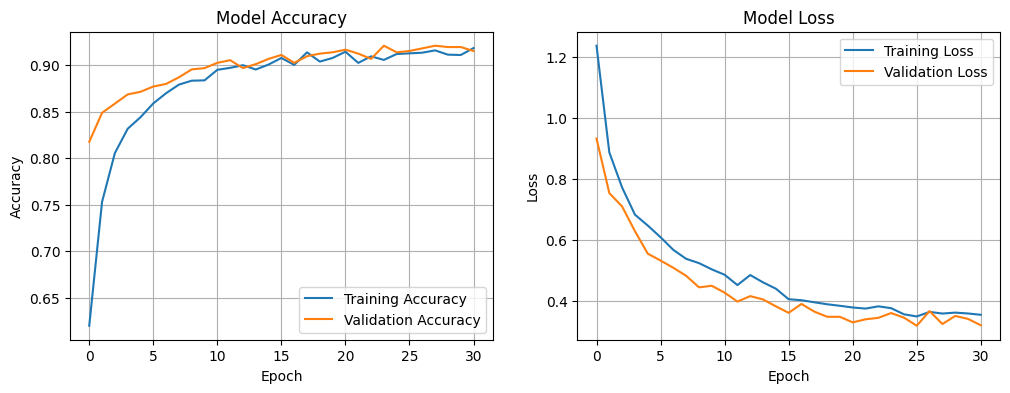

In [15]:
# Plot training and validation
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid()

plt.show()

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9191 - loss: 0.3108
Test Loss: 0.3181, Test Accuracy: 0.9151


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

Speech Delay       0.90      0.90      0.90       309
     Healthy       0.92      0.92      0.92       398

    accuracy                           0.92       707
   macro avg       0.91      0.91      0.91       707
weighted avg       0.92      0.92      0.92       707



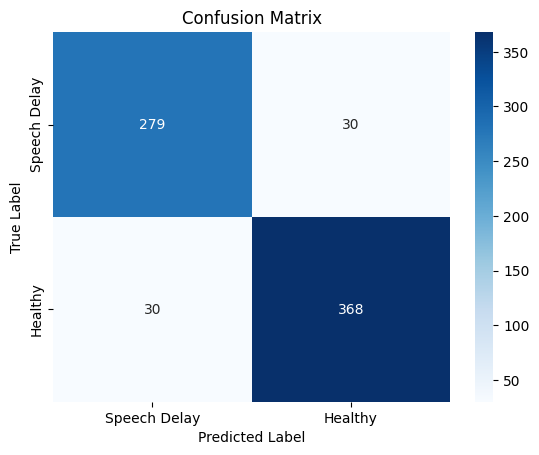

In [17]:
# Display model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=["Speech Delay", "Healthy"]))

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Speech Delay", "Healthy"],
            yticklabels=["Speech Delay", "Healthy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Classify uploaded file

In [18]:
# Function to detect noise
def is_noisy(audio_path):
    audio, sr = librosa.load(audio_path, sr=None)
    energy = np.mean(np.square(audio))
    return energy < 1e-4

In [19]:
# Upload audio file
uploaded = files.upload()

# Function to classify uploaded audio file
def classify_uploaded_audio():
    # Get the uploaded file path
    audio_path = '/content/' + list(uploaded.keys())[0]

    # Load the audio file and preprocess it
    waveform, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Extract YAMNet features
    features = extract_yamnet_features(waveform)
    features = np.expand_dims(features, axis=0)

    # Predict using the trained model
    prediction = model.predict(features)[0][0]

    # Map prediction to class
    if prediction >= 0.5 and is_noisy(audio_path):
        result = "Masih Salah, Coba Lagi"
    elif prediction >= 0.5:
        result = "Bagus, Mari Lanjutkan"
    else:
        result = "Masih Salah, Coba Lagi"

    print(f"Prediction: {result} (Score: {prediction:.4f})")
    os.remove(audio_path) # Delete audio after used
    return result, prediction

# Step 3: Run the classification function
classify_uploaded_audio()

Saving WhatsApp Audio 2024-12-02 at 19.24.05_df0ed7d1.opus to WhatsApp Audio 2024-12-02 at 19.24.05_df0ed7d1.opus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Masih Salah, Coba Lagi (Score: 0.0000)


('Masih Salah, Coba Lagi', 1.0367181e-08)

## Save and download the model

In [20]:
# Save the model
model.save('speech_classification_model.h5')

# Download the model file
files.download('speech_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>